In [ ]:
PS C:\Users\howar\Desktop\brain-tumor-detection-vgg19> python -m venv brain-tumor-detection-vgg19_env
PS C:\Users\howar\Desktop\brain-tumor-detection-vgg19> .\brain-tumor-detection-vgg19_env\Scripts\activate
pip install pandas numpy matplotlib opencv-python seaborn tensorflow imutils scikit-learn ipykernel
python -m ipykernel install --user --name=brain-tumor-detection-vgg19_env --display-name "Python (Brain Tumor Project)"

SyntaxError: unexpected character after line continuation character (552083672.py, line 1)

In [ ]:
#https://colab.research.google.com/drive/1v8nevSqwC1EIaTBf9ahyait0iBhv92Bp?usp=sharing#scrollTo=k6Otbn5P5owy

In [ ]:
!python -m venv brain_env

In [ ]:
!.\brain_env\Scripts\activate
pip install ipykernel
python -m ipykernel install --user --name=brain_env --display-name "Python (Brain Tumor Project)"
pip install pandas numpy matplotlib opencv-python seaborn

In [5]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# Dataset
import zipfile

z = zipfile.ZipFile('archive.zip')

z.extractall()

In [6]:
folder = 'yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'yes/Y_10.jpg' -> 'yes/Y_2.jpg'

In [ ]:
folder = 'no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [ ]:
import os
import cv2

yes_path = "yes/"
no_path = "no/"

os.makedirs(yes_path, exist_ok=True)
os.makedirs(no_path, exist_ok=True)

def count_real_jpg(folder_path):
    count = 0
    for f in os.listdir(folder_path):
        if f.lower().endswith(".jpg"):
            full_path = os.path.join(folder_path, f)
            img = cv2.imread(full_path)
            if img is not None:
                count += 1
    return count

number_files_yes = count_real_jpg(yes_path)
print(number_files_yes)

number_files_no = count_real_jpg(no_path)
print(number_files_no)

155
98


In [ ]:
# for 115: 98 yes/no imbalance, we will use augmentation on the no part to deal with the imbalance 

# Preprocessing

In [ ]:
pip install tensorflow 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
# timing block
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"


In [9]:
# random rotae 10 degrees, draken, move, flip the image, 
# fill the color of nearest pixel for empty space created by rotation
# since the tumor can appear in either side, flip the image should be fine 
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    os.makedirs(save_to_dir, exist_ok=True)
    # only check 1 image vector printed out by setting a flag 
    first_img_flag = True 
    for filename in os.listdir(file_dir):
        image_path = os.path.join(file_dir, filename)
        # cv2.imread: read image into original resolution and RGB color mode (3 channels)
        image = cv2.imread(image_path)

        if image is None:
            continue
        image = image.reshape((1,)+image.shape)
        save_prefix ="aug_" + filename[:-4]

        i=0
        for batch in data_gen.flow(
            x=image,
            batch_size =1,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format="jpg"
        ):
            if first_img_flag:
                print("--- EXAMPLE VECTOR (Showing only once) ---")
                print(f"Shape: {batch.shape}")
                print(f"First pixel: {batch[0,0,0,:]}")
                first_img_flag = False  # <--- 3. Turn it off immediately
            i+=1
            if i >= n_generated_samples:
                break

In [10]:
import time
start_time = time.time()

yes_path = 'yes'
no_path = 'no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')
# no: 98 * 9 = 882
# yes: 155 * 6 = 930

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

--- EXAMPLE VECTOR (Showing only once) ---
Shape: (1, 218, 180, 3)
First pixel: [0. 0. 0.]


KeyboardInterrupt: 

In [ ]:
#Shape: (1, 218, 180, 3)
# 1 image at a time, 218 ,180 height and width
# 3 color channels 

In [ ]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")    

In [ ]:
data_summary(augmented_data_path)


Number of sample: 1814
932 Number of positive sample in percentage: 51.37816979051819%
882 Number of negative sample in percentage: 48.62183020948181%


In [ ]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

932
882


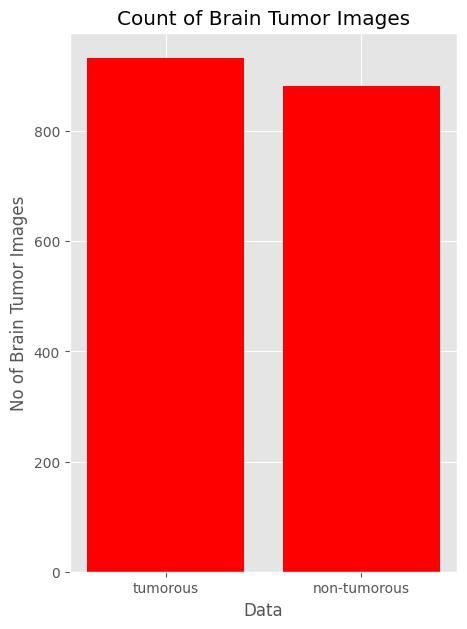

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
# 1. Cleaning the noise 
# Color conversion: BGR to Gray (MRI scans are monochromatic) -cvtcolor 
# GaussianBlur: Apply a slight blur, Smooth out  random bright pixels that could be mistaken for actual brain tissue
# 2. Segmention (isolating the brain)
# Threshold : any pixel darker than 45 becomes 0 (black) - thres
# erosion : eats away at the edges to remove tiny floating noise
# dilation: grows the edge back
# 3. Finding the extreme points 
# findcontours: identify outlines of all white shapes in the threshold image 
# max (cnts,..) : it assumes the largest white space in the image is the brain / skull
# extreme coordinates (left, right, top..)
# 4. Cropping and Output
# new_image = image [], use standard numpy slicing the cut the original image based on those 4 extreme points
# use matplotlib to show before vs after comparison


In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
    #image: input array 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    # x coordinate
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image





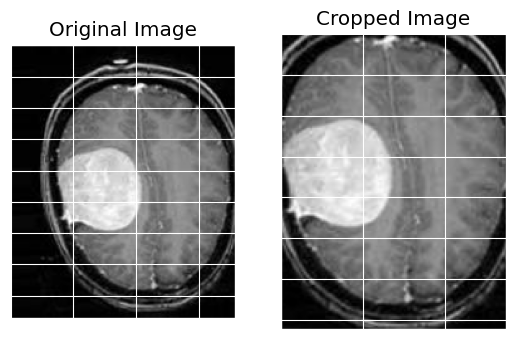

array([[[ 4,  4,  4],
        [ 5,  5,  5],
        [ 5,  5,  5],
        ...,
        [ 3,  3,  3],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       [[ 5,  5,  5],
        [ 6,  6,  6],
        [ 7,  7,  7],
        ...,
        [ 4,  4,  4],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       [[ 6,  6,  6],
        [ 3,  3,  3],
        [ 0,  0,  0],
        ...,
        [ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3]],

       ...,

       [[ 8,  8,  8],
        [ 5,  5,  5],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[11, 11, 11],
        [ 9,  9,  9],
        [ 7,  7,  7],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[12, 12, 12],
        [13, 13, 13],
        [13, 13, 13],
        ...,
        [ 0,  0,  0],
        [ 1,  1,  1],
        [ 1,  1,  1]]], shape=(181, 138, 3), dtype=uint8)

In [ ]:
img = cv2.imread('augmented_data/yes/aug_Y_1_0_857.jpg')
crop_brain_tumor(img, True)

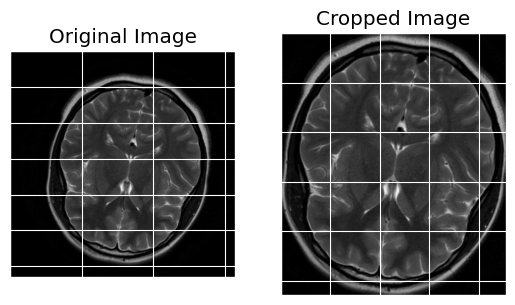

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(529, 455, 3), dtype=uint8)

In [ ]:
img = cv2.imread('augmented_data/no/aug_N_1_0_1700.jpg')
crop_brain_tumor(img, True)

In [12]:
# crop and overwrite images
import os
import cv2
folder_yes = 'augmented_data/yes/'
folder_no = 'augmented_data/no/'

def process_and_overwrite(folder_path):
    print(f"Processing folder: {folder_path}")
    files = os.listdir(folder_path)
    count_ok = 0
    count_err = 0

    for filename in files:
        path = os.path.join(folder_path, filename)
        
        # Read image
        img = cv2.imread(path)
        if img is None:
            count_err += 1
            continue

        try:
            # Crop using the function you defined earlier
            img = crop_brain_tumor(img, plot=False)
            
            # Overwrite the file
            cv2.imwrite(path, img)
            count_ok += 1
        except Exception as e:
            print(f" -> Error cropping {filename}: {e}")
            count_err += 1
    print(f"Finished: {count_ok} successfully cropped, {count_err} skipped/failed.")

# Execute
process_and_overwrite(folder_yes)
process_and_overwrite(folder_no)
        


Processing folder: augmented_data/yes/
 -> Error cropping aug_Y_100_0_1312.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_151.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_2056.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_2642.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_3354.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_4660.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_6351.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_7540.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_7774.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_8775.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_9586.jpg: name 'crop_brain_tumor' is not defined
 -> Error cropping aug_Y_100_0_9671.jpg: name 'crop_brain_tumor' is not defined
 -

KeyboardInterrupt: 

In [13]:
# manual data split (train/ test/ valid)

import os 
import shutil
# 1. set up directories
base_dir = "tumorous_and_nontumorous"
subsets = ["train","test","valid"]
classes = ["tumorous",'nontumorous']

for subset in subsets:
    for cls in classes:
        os.makedirs(os.path.join(base_dir,subset,cls),exist_ok = True)

# 2. define source paths
src_yes = 'augmented_data/yes/'  # Maps to 'tumorous'
src_no = 'augmented_data/no/'    # Maps to 'nontumorous'
# 3. helper function to copy files by index range
def copy_range(src_folder, dest_folder, start_idx, end_idx):
    # get valid file only
    files = [ f for f in os.listdir(src_folder) if f.endswith('.jpg')]
    files.sort()

    max_files = len (files)
    end_idx = min (end_idx, max_files)
    selected_files = files[start_idx:end_idx] 
    print(f"Copying {len(selected_files)} files to {dest_folder}...")
    for fname in selected_files:
        shutil.copyfile(os.path.join(src_folder, fname), os.path.join(dest_folder, fname))
# total yes / tumorous 932 images  
copy_range(src_yes, os.path.join(base_dir, "train", "tumorous"), 0, 799)    # 0 to 799
copy_range(src_yes, os.path.join(base_dir, "test", "tumorous"), 799, 899)   # 799 to 899
copy_range(src_yes, os.path.join(base_dir, "valid", "tumorous"), 899, 1000) # 899 to End


# --- EXECUTE SPLIT (NO / NONTUMOROUS) ---
# Total No ~882 images
copy_range(src_no, os.path.join(base_dir, "train", "nontumorous"), 0, 719)   # 0 to 719
copy_range(src_no, os.path.join(base_dir, "test", "nontumorous"), 719, 809)  # 719 to 809
copy_range(src_no, os.path.join(base_dir, "valid", "nontumorous"), 809, 1000) # 809 to End






Copying 799 files to tumorous_and_nontumorous\train\tumorous...
Copying 100 files to tumorous_and_nontumorous\test\tumorous...
Copying 101 files to tumorous_and_nontumorous\valid\tumorous...
Copying 719 files to tumorous_and_nontumorous\train\nontumorous...
Copying 90 files to tumorous_and_nontumorous\test\nontumorous...
Copying 73 files to tumorous_and_nontumorous\valid\nontumorous...


In [14]:
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data generation

#1. train generator
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip = 0.4,
    vertical_flip = 0.4,
    rotation_range = 40,
    shear_range = 0.2,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    fill_mode = 'nearest'
)


#2. test / valid generator (no augmentation, only scaling)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

#3. flow from directory
BATCH_SIZE = 32
# best size for RAM memory
IMG_SIZE = (224, 224) # Standard for VGG19, changed from 240 to be safe
print("\n--- Training Set ---")
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
test_generator = train_datagen.flow_from_directory( # FIXED: Used test_data_gen
    os.path.join(base_dir, 'test'),
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle=False # Usually False for testing so you can match predictions to filenames
)

print("\n--- Validation Set ---")
valid_generator = train_datagen.flow_from_directory( # FIXED: Used test_data_gen
    os.path.join(base_dir, 'valid'),
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle=True
)
print("\n--- Test Set ---")
test_generator = train_datagen.flow_from_directory( # FIXED: Used test_data_gen
    os.path.join(base_dir, 'test'),
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
    shuffle=False # Usually False for testing so you can match predictions to filenames
)
# get class names 
class_labels = train_generator.class_indices
class_name = {value: key for (key, value) in class_labels.items()}
print(f"\nClasses: {class_name}")
# seed = 42 - pop culture, shuffling random but repeatable, one run get easy batch, one run get hard batch
# shuffle = true - randomize the order of image - if all first 100 no or yes, they mix up



--- Training Set ---
Found 1676 images belonging to 2 classes.
Found 290 images belonging to 2 classes.

--- Validation Set ---
Found 207 images belonging to 2 classes.

--- Test Set ---
Found 290 images belonging to 2 classes.

Classes: {0: 'nontumorous', 1: 'tumorous'}


In [ ]:
# build up and compile model

In [15]:
# vgg 19: convolutional neural network
# simplicity : uniform architecture (stacks of 3x3 convultional filters)-easy to fine tune
# Transfer learning pretrained weight: weight = 'imagenet'
# pro: high accuracy for image classification 
# cons: large, heavy on memory, slower to train new models
# other options: ResNet50, InceptionV3, MobileNet, EfficientNet

#Optimizer: Stochastic Gradient Descent SGD
#learning_rate = 0.001 (small steps)
# momentum = 0.9
# other option: Adam

#Reduce Learning Rage on Plateau, watch val_accuracy- if accuracy stop improving for patience = 3 epoch (3 rounds of training, it reduces the learning rate by factor =0.5 cut the step size in half, model take smaller and finer steps)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD

# 1. load VGG19 with 'imagenet' weights automatically
base_model = VGG19(input_shape=(224, 224, 3),
    include_top=False,weights = None)
 # <--- FIXED:Pretrained model from me
base_model.load_weights(
"vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

#2. freeze the base layer so we don't destroy pre-trained patterns
for layer in base_model.layers:
    layer.trainable = False 

# 3. add custom classification layers 
# build head of neural network.
# base part as eye to see the pattern 
x = base_model.output
flat = Flatten()(x)
# 4608 number of neuron - 4 x 1152
# mathematical function of each neuron: 'if the value is negative, turn it to 0, if it's positive, keep it'
# to learn non-linear pattern without getting stuck, for hidden layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
# drop out: 20 %- during each round of training, randomly turns off 20% of the neuron in previous layer. prevent overfitting
# don't let model rely on any single specific neuron to make a decision, don't memorize specific path  
class_2= Dense(1152, activation='relu')(drop_out)
# 1152: compress the information further ,"funnel"
output= Dense(2, activation='softmax')(class_2)
# for keras API, every layer need what it is and where it comes from 

# 2 : the final decision output size yes / no  catogoires
# softmax: turn the decision into a readanle percentage , Example Output: [0.95, 0.05]

model_01 = Model (base_model.input, output)
model_01.summary()

#4. define callback, assistants to watch model while it trains, pause, save , adjust settings
filepath = 'model.h5'
# "the quitter "
# val_loss: error rate on new data
#if the error does not decrease for 4 epochs in a row, stop training to prevent overfitting (memorizing the answer key rather than learning the rules)
es = EarlyStopping(monitor='val_loss', verbose =1, mode= 'min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
# "Autosave"
# save_best_only=True: save / overwrite - single best version at the end
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)
#fine tuner"
# factor = 0.5, it cut the learing rate in half
# min_lr= 0.001: the lower bound limit of the learning rate

#5. compile
sgd =SGD(learning_rate=0.0001, momentum= 0.9, nesterov=True)
model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



# Train
history_01 = model_01.fit(
    train_generator,
    epochs=10,  # Increased from 2 to see actual learning
    callbacks=[es, cp, lrr],
    validation_data=valid_generator
)

# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5666 - loss: 0.7410
Epoch 1: val_loss improved from None to 0.62204, saving model to model.h5



Epoch 1: finished saving model to model.h5
53/53 ━━━━━━━━━━━━━━━━━━━━ 594s 11s/step - accuracy: 0.5919 - loss: 0.6860 - val_accuracy: 0.6667 - val_loss: 0.6220 - learning_rate: 1.0000e-04
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6183 - loss: 0.6523
Epoch 2: val_loss did not improve from 0.62204
53/53 ━━━━━━━━━━━━━━━━━━━━ 552s 10s/step - accuracy: 0.6289 - loss: 0.6435 - val_accuracy: 0.5217 - val_loss: 0.7613 - learning_rate: 1.0000e-04
Epoch 3/10
32/53 ━━━━━━━━━━━━━━━━━━━━ 2:58 9s/step - accuracy: 0.6781 - loss: 0.6115

KeyboardInterrupt: 